## Import the required libraries

In [230]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from datetime import timedelta,datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

## Read datasets

In [455]:
games = pd.read_csv('Casino games.csv')
users = pd.read_csv('Casino Users.csv') 
wallet = pd.read_csv('Customer Wallet.csv')


## Exploratory analysis 

### Games

In [3]:
# Data types
games.dtypes

Casino_Provider     object
UserID               int64
IsJackpotWinID       int64
IsFreeSpinID         int64
Date                object
IsLiveID             int64
Hold               float64
dtype: object

In [91]:
# Shape, unique ids, check for duplicates
len(games),games.UserID.nunique(),len(games.drop_duplicates())

(9823921, 153350, 9823921)

In [70]:
# count nulls per column
games.isnull().sum()

Casino_Provider    0
UserID             0
IsJackpotWinID     0
IsFreeSpinID       0
Date               0
IsLiveID           0
Hold               0
dtype: int64

### Users

In [39]:
users.dtypes

UserProfileId         int64
BirthDate            object
ZipCode              object
CountryName          object
Sex                  object
Registration Date    object
City                 object
CountryId             int64
StatusSysname        object
dtype: object

In [95]:
len(users),users.UserProfileId.nunique(),len(users.drop_duplicates())

(10641, 6029, 6258)

In [69]:
users.isnull().sum()

UserProfileId        0
BirthDate            0
ZipCode              0
CountryName          0
Sex                  0
Registration Date    0
City                 0
CountryId            0
StatusSysname        0
dtype: int64

In [97]:
len(users),users.UserProfileId.nunique(),len(users.drop_duplicates())

(6029, 6029, 6029)

### Wallet

In [40]:
wallet.dtypes

WalletActionId      int64
UserProfileId       int64
Type                int64
TypeSysname        object
Amount            float64
MethodSysname      object
Created            object
dtype: object

In [68]:
wallet.isnull().sum()

WalletActionId    0
UserProfileId     0
Type              0
TypeSysname       0
Amount            0
MethodSysname     0
Created           0
dtype: int64

In [98]:
len(wallet),wallet.UserProfileId.nunique(),len(wallet.drop_duplicates())

(38294, 2392, 38294)

## Cleansing

In [456]:
# Rename columns
users = users.rename({'UserProfileId': 'UserID'}, axis=1) 
wallet= wallet.rename({'UserProfileId': 'UserID'}, axis=1) 

# Abs values
wallet['Amount'] = wallet['Amount'].abs()

# String to datetime format (for Frequency,Recency and age kpis)
wallet['Created'] = pd.to_datetime(wallet['Created'])
games['Date'] = pd.to_datetime(games['Date'])
users['BirthDate'] = pd.to_datetime(users['BirthDate'])

# Order by date (for Frequency kpi (shift step))
wallet = wallet.sort_values(by=['Created'], ascending=True)
games = games.sort_values(by=['Date'], ascending=True)

# Drop dups
users = users.drop_duplicates(subset='UserID', keep='first')

## Create KPIs

### Most popular games

In [457]:
# Calculate number of appearance per casino game 
popular_games = games.groupby('Casino_Provider').agg({'Casino_Provider':['count']})
# Flatten multi index
popular_games = popular_games.Casino_Provider
popular_games = popular_games.reset_index()
popular_games.sort_values(by=['count'],ascending=False)

,Casino_Provider,count
9,PlayTech,2800617
8,PlayNGo,1977991
10,PragmaticPlay,1474608
6,Nyx,946275
5,NetEnt,861109
3,Iforium,846699
11,RedTiger,604913
12,Skywind,138956
1,Evolution,117923
7,Oryx,30383


Text(0, 0.5, 'Number of appearance')

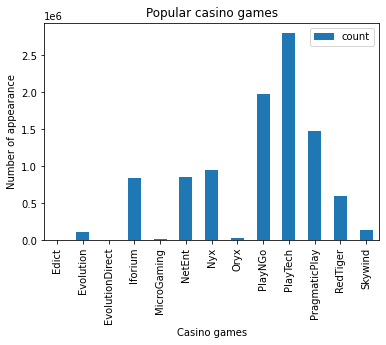

In [9]:
# Bar plot
popular_games.plot.bar(x="Casino_Provider", y="count", title="Popular casino games");
plt.xlabel("Casino games")
plt.ylabel("Number of appearance")

#### PlayTech is the casino game that appears the most times

In [75]:
# How much does a casino hold on average (good for casino-bad for player) ? 
hold_mean_games = games.groupby(['Casino_Provider']).agg({'Hold':['mean']})
hold_mean_games

,Hold
,mean
Casino_Provider,
Edict,264.876653
Evolution,569.712408
EvolutionDirect,-90.064903
Iforium,195.928262
MicroGaming,346.403214
NetEnt,57.989146
Nyx,139.597824
Oryx,116.856932


### Most profitable games

In [10]:
# Calculate max and min hold values per casino game 
profit_games = games.groupby('Casino_Provider').agg({'Hold': ['min', 'max']})
# multi index to single index
profit_games = profit_games.Hold
profit_games = profit_games.reset_index()
profit_games

,Casino_Provider,min,max
0,Edict,-2.146252e+05,8.149306e+04
1,Evolution,-3.581500e+06,7.160386e+06
2,EvolutionDirect,-3.643297e+05,2.487654e+04
3,Iforium,-1.352475e+06,4.935180e+05
4,MicroGaming,-6.724329e+05,3.383730e+05
5,NetEnt,-4.197709e+05,2.972727e+05
6,Nyx,-2.202665e+06,1.075561e+06
7,Oryx,-2.865026e+05,7.467360e+04
8,PlayNGo,-1.825303e+06,2.695395e+05
9,PlayTech,-1.869985e+07,1.617226e+07


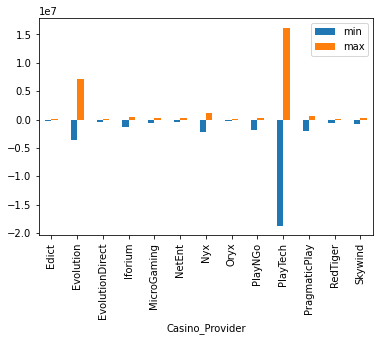

In [444]:
# Bar plot
profit_games.set_index('Casino_Provider').plot.bar()
plt.show()

#### Similarly, PlayTech is the casino game with the highest return (in favor of casino)

###  Frequency :average days between actions

In [458]:
# Get the previous action date 
wallet['previous_action'] = wallet.groupby(['UserID', 'TypeSysname'])['Created'].shift()
# Calculate the days passed between actions
wallet['Frequency'] = wallet['Created'] - wallet['previous_action']
# Difference in days
wallet['Frequency'] = wallet['Frequency'].apply(lambda x: x.days)

# Avg days between actions per user and type of action
Frequency=wallet.groupby(['UserID', 'TypeSysname']).agg({'Frequency':['mean']})
Frequency=Frequency.Frequency
Frequency=Frequency.reset_index() 
Frequency = Frequency.rename({'mean': 'Frequency'}, axis=1) 

Frequency=Frequency.fillna(0) # when user has made only one single date a action, gets frequency 0
Frequency=Frequency.round(1)

#Pivot table
Frequency_trn = Frequency.pivot_table(index=['UserID'], 
                                      columns='TypeSysname', 
                                      values=['Frequency'], aggfunc='first',fill_value=0)
Frequency_trn.columns = [f'{b}_{a}' for a, b in Frequency_trn.columns]
Frequency_trn = Frequency_trn.reset_index()
Frequency_trn

,UserID,DEPOSIT_Frequency,WITHDRAW_Frequency
0,1248186,3.7,0.0
1,1358038,12.0,0.0
2,1453264,0.0,0.0
3,1497852,5.3,0.0
4,1503909,2.2,32.0
...,...,...,...
2387,1574047,0.0,0.0
2388,1574102,0.0,0.0
2389,1574105,0.0,0.0
2390,1574162,0.0,0.0


### Recency :days passed since the last action made

In [459]:
# Get the last action date of wallet dataset
wallet['max_date'] = wallet['Created'].max() + timedelta(days=1)
# Calculate days passed between action date and last action date
wallet['Recency']= wallet['max_date']-wallet['Created']
# Difference in days
wallet['Recency'] = wallet['Recency'].apply(lambda x: x.days)

# Get the min value (i.e. days since last user's action) per user and type of action
Recency = wallet.groupby(['UserID','TypeSysname']).agg({'Recency':['min']})
Recency = Recency.Recency
Recency = Recency.reset_index() 
Recency = Recency.rename({'min': 'Recency'}, axis=1) 

#Pivot table
Recency_trn = Recency.pivot_table(index=['UserID'], 
                                  columns='TypeSysname', 
                                  values=['Recency'], aggfunc='first',fill_value=0)
Recency_trn.columns = [f'{b}_{a}' for a, b in Recency_trn.columns]
Recency_trn = Recency_trn.reset_index()
Recency_trn

,UserID,DEPOSIT_Recency,WITHDRAW_Recency
0,1248186,40,0
1,1358038,32,0
2,1453264,52,0
3,1497852,24,24
4,1503909,1,12
...,...,...,...
2387,1574047,1,0
2388,1574102,1,0
2389,1574105,1,0
2390,1574162,1,0


In [460]:
#Recency.loc[Recency.UserID==1503909]

### Monetary: Total and average amount of action

In [461]:
# Calculate total and avg amount per user & action type
Avg_amount_type = wallet.groupby(['UserID','TypeSysname']).agg({'Amount':['sum','mean']})
Avg_amount_type = Avg_amount_type.Amount
Avg_amount_type = Avg_amount_type.reset_index() 

#Pivot table
Avg_amount_type_trn = Avg_amount_type.pivot_table(index=['UserID'], 
                                              columns='TypeSysname', 
                                              values=['sum','mean'], aggfunc='first',fill_value=0)
Avg_amount_type_trn.columns = [f'{b}_{a}' for a, b in Avg_amount_type_trn.columns]
Avg_amount_type_trn = Avg_amount_type_trn.reset_index()
#Avg_amount_type_trn

### Profit or loss per user 

In [462]:
# Calculate difference between deposit and withdraw amounts
Avg_amount_type_trn['Dif']=Avg_amount_type_trn['WITHDRAW_sum']-Avg_amount_type_trn['DEPOSIT_sum']
Avg_amount_type_trn['Dif']=Avg_amount_type_trn['Dif'].astype(float)

Avg_amount_type_trn.loc[(Avg_amount_type_trn['Dif'] > 0), 'Profit or Loss'] = 'Profit'
Avg_amount_type_trn.loc[(Avg_amount_type_trn['Dif'] < 0), 'Profit or Loss'] = 'Loss'
Avg_amount_type_trn=Avg_amount_type_trn[['UserID','DEPOSIT_mean','WITHDRAW_mean','DEPOSIT_sum','WITHDRAW_sum','Profit or Loss']]


In [133]:
#games.loc[games.UserID==1503909]

### Number of transactions per casino game

In [463]:
# Count how many times a user has played each casino game
games_user_count = games.groupby(['UserID','Casino_Provider']).agg({'UserID':['count']})
games_user_count = games_user_count.UserID
games_user_count = games_user_count.reset_index() 

#Pivot table
games_user_count_trn = games_user_count.pivot_table(index=['UserID'], 
                                              columns='Casino_Provider', 
                                              values=['count'], aggfunc='first',fill_value=0)
games_user_count_trn.columns = [f'{b}_{a}' for a, b in games_user_count_trn.columns]
games_user_count_trn = games_user_count_trn.reset_index()
#games_user_count_trn

In [72]:
# Average hold amount per user & casino game
games_hold_avg = games.groupby(['UserID','Casino_Provider']).agg({'Hold':['mean']})
games_hold_avg = games_hold_avg.Hold
games_hold_avg = games_hold_avg.reset_index()
games_hold_avg.loc[games_hold_avg.UserID==1503909]

,UserID,Casino_Provider,mean
755705,1503909,Iforium,1108.342308
755706,1503909,NetEnt,284.690000
755707,1503909,Nyx,-156.065000
755708,1503909,PlayNGo,-17.150000
755709,1503909,PlayTech,222.950000
755710,1503909,PragmaticPlay,20.160000
755711,1503909,Skywind,1035.533333


### Frequency of transactions per casino game

In [464]:
# Get the previous transaction date 
games['previous_transaction'] = games.groupby(['UserID', 'Casino_Provider'])['Date'].shift()
# Calculate the days passed between transaction
games['Frequency'] = games['Date'] - games['previous_transaction']
# Difference in days
games['Frequency'] = games['Frequency'].apply(lambda x: x.days)

# Avg days between transactions per user and casino game
Frequency_games=games.groupby(['UserID', 'Casino_Provider']).agg({'Frequency':['mean']})
Frequency_games=Frequency_games.Frequency
Frequency_games=Frequency_games.reset_index() 
Frequency_games = Frequency_games.rename({'mean': 'Frequency'}, axis=1) 

Frequency_games=Frequency_games.fillna(0) # when user has made only one transaction on a casino game, gets frequency 0
Frequency_games=Frequency_games.round(1)

#Pivot table
Frequency_games_trn = Frequency_games.pivot_table(index=['UserID'], 
                                                  columns='Casino_Provider', 
                                                  values=['Frequency'], aggfunc='first',fill_value=0)
Frequency_games_trn.columns = [f'{b}_{a}' for a, b in Frequency_games_trn.columns]
Frequency_games_trn = Frequency_games_trn.reset_index()
Frequency_games_trn

,UserID,Edict_Frequency,Evolution_Frequency,EvolutionDirect_Frequency,Iforium_Frequency,MicroGaming_Frequency,NetEnt_Frequency,Nyx_Frequency,Oryx_Frequency,PlayNGo_Frequency,PlayTech_Frequency,PragmaticPlay_Frequency,RedTiger_Frequency,Skywind_Frequency
0,99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,104,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,105,0.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,582983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
4,583003,0.0,0.0,0.0,0.0,0.0,9.7,0.0,0.0,4.3,3.0,4.2,10.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153345,1575178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
153346,1575184,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
153347,1575186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
153348,1575189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [96]:
#games.loc[games.UserID==1575206]

### Average JackpotWin per casino game

In [465]:
jackpot = games.groupby(['UserID','Casino_Provider']).agg({'IsJackpotWinID':['mean']})
jackpot=jackpot.IsJackpotWinID
jackpot=jackpot.reset_index() 
jackpot = jackpot.rename({'mean': 'JackpotWin_avg'}, axis=1) 

#Pivot table
jackpot_trn = jackpot.pivot_table(index=['UserID'], 
                                  columns='Casino_Provider', 
                                  values=['JackpotWin_avg'], aggfunc='first',fill_value=0)
jackpot_trn.columns = [f'{b}_{a}' for a, b in jackpot_trn.columns]
jackpot_trn = jackpot_trn.reset_index()
jackpot_trn

,UserID,Edict_JackpotWin_avg,Evolution_JackpotWin_avg,EvolutionDirect_JackpotWin_avg,Iforium_JackpotWin_avg,MicroGaming_JackpotWin_avg,NetEnt_JackpotWin_avg,Nyx_JackpotWin_avg,Oryx_JackpotWin_avg,PlayNGo_JackpotWin_avg,PlayTech_JackpotWin_avg,PragmaticPlay_JackpotWin_avg,RedTiger_JackpotWin_avg,Skywind_JackpotWin_avg
0,99,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0
1,104,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0
2,105,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0
3,582983,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0
4,583003,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153345,1575178,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0
153346,1575184,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0
153347,1575186,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0
153348,1575189,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0


### Average FreeSpin per casino game

In [466]:
spin = games.groupby(['UserID','Casino_Provider']).agg({'IsFreeSpinID':['mean']})
spin= spin.IsFreeSpinID
spin= spin.reset_index() 
spin = spin.rename({'mean': 'IsFreeSpinID_avg'}, axis=1) 

#Pivot table
spin_trn = spin.pivot_table(index=['UserID'], 
                            columns='Casino_Provider', 
                            values=['IsFreeSpinID_avg'], aggfunc='first',fill_value=0)
spin_trn.columns = [f'{b}_{a}' for a, b in spin_trn.columns]
spin_trn = spin_trn.reset_index()
spin_trn

,UserID,Edict_IsFreeSpinID_avg,Evolution_IsFreeSpinID_avg,EvolutionDirect_IsFreeSpinID_avg,Iforium_IsFreeSpinID_avg,MicroGaming_IsFreeSpinID_avg,NetEnt_IsFreeSpinID_avg,Nyx_IsFreeSpinID_avg,Oryx_IsFreeSpinID_avg,PlayNGo_IsFreeSpinID_avg,PlayTech_IsFreeSpinID_avg,PragmaticPlay_IsFreeSpinID_avg,RedTiger_IsFreeSpinID_avg,Skywind_IsFreeSpinID_avg
0,99,0,0,0.0,0.0,0,0.000000,0.0,0,0.000000,0.00,0.000000,0.0,0.0
1,104,0,0,0.0,0.0,0,0.000000,0.0,0,0.000000,0.00,0.000000,0.0,0.0
2,105,0,0,0.0,0.0,0,0.000000,0.0,0,0.000000,0.00,0.000000,0.0,0.0
3,582983,0,0,0.0,0.0,0,1.000000,0.0,0,0.000000,0.50,1.000000,1.0,0.0
4,583003,0,0,0.0,0.0,0,0.857143,1.0,0,0.923077,0.85,0.785714,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153345,1575178,0,0,0.0,0.0,0,0.000000,0.0,0,0.000000,0.00,0.000000,0.0,0.0
153346,1575184,0,0,0.0,0.0,0,0.000000,0.0,0,0.000000,0.00,0.000000,0.0,0.0
153347,1575186,0,0,0.0,0.0,0,0.000000,0.0,0,0.000000,0.00,0.000000,0.0,0.0
153348,1575189,0,0,0.0,0.0,0,0.000000,0.0,0,0.000000,0.00,0.000000,0.0,0.0


### Age of users 

In [467]:
curr_time = pd.to_datetime("now")
users['Age']=(curr_time - users['BirthDate']).astype('<m8[Y]')

## Create the dataset for clustering: 
It includes: 1. customers who are in customer database (users df)
             2. customers with customer wallet info (wallet df) and 
             3. customers who have made a transaction on a casino game (casino games df)

In [482]:
combined_df= users[['UserID']].merge(Frequency_trn,on='UserID',how='inner').merge(Recency_trn,on='UserID',how='inner').merge(Avg_amount_type_trn,on='UserID',how='inner').merge(games_user_count_trn,on='UserID',how='inner').merge(Frequency_games_trn,on='UserID',how='inner')
# The user 1529537 is outlier -> remove him
combined_df=combined_df.loc[combined_df.UserID!=1529537]
combined_df.reset_index(drop=True,inplace=True)
combined_df.shape

(1313, 36)

## Data model preparation

### 1. Correlation matrix

<AxesSubplot:>

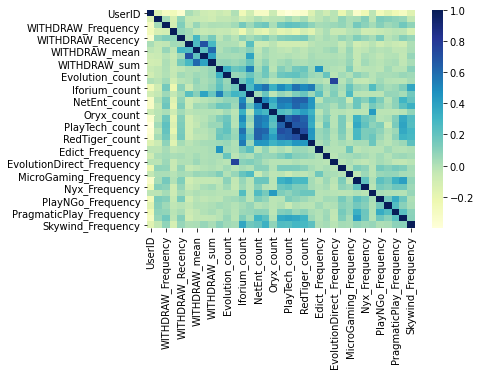

In [483]:
corr_plot = sb.heatmap(combined_df.corr(), cmap="YlGnBu")
corr_plot

In [484]:
# Remove columns based on correlation insights
combined_df2=combined_df.drop(['DEPOSIT_sum','WITHDRAW_sum','EvolutionDirect_count','PragmaticPlay_count'], axis = 1)


### 2. One hot encoding for factors 

In [485]:
one_hot_df=pd.get_dummies(combined_df2['Profit or Loss'])
one_hot_df.reset_index(drop=True,inplace=True)
del combined_df2['Profit or Loss']
combined_df3 = pd.concat([combined_df2, one_hot_df], axis=1)

### 3. Standardization 

In [488]:
# Remove binaries from std process
Binaries = ['Profit','Loss']
df_to_std = combined_df3.drop(Binaries, 1) 
Binaries_df = combined_df3[Binaries]
df_to_std_names = df_to_std.iloc[: , 1:].columns # remove UserID and then get column names

# Std only numerics
df_to_std = StandardScaler().fit_transform(df_to_std.iloc[: , 1:]) 
df_to_std = pd.DataFrame(df_to_std)
df_to_std.columns = df_to_std_names # rename columns appropriatly 

# Bring together numeric features and binary 
combined_df4 = pd.concat([df_to_std, Binaries_df], axis=1)

### 4. Convert to array 

In [489]:
combined_df5 = combined_df4.values

## Optimal number of clusters 

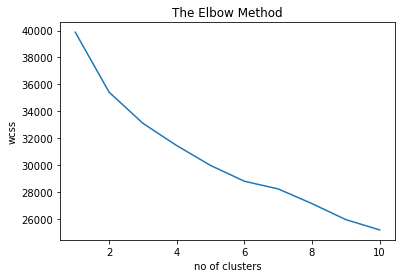

In [490]:
# Elbow Method: small inertia

score = []

for cluster in range(1,11):
    kmeans = KMeans(n_clusters = cluster, init="k-means++", random_state=10)
    kmeans.fit(combined_df5)
    score.append(kmeans.inertia_)
    
# plotting the score

plt.plot(range(1,11), score)
plt.title('The Elbow Method')
plt.xlabel('no of clusters')
plt.ylabel('wcss')
plt.show()

In [491]:
# Silhouette score: close to 1 

for clusters in range(2,11):
 
 kmeans = KMeans(n_clusters=clusters)
 kmeans.fit(combined_df5)
 cluster_labels = kmeans.labels_
 print("On cluster:",clusters,"Silhouette score:",silhouette_score(combined_df5, cluster_labels))

On cluster: 2 Silhouette score: 0.21701530109278616
On cluster: 3 Silhouette score: 0.1749818716218115
On cluster: 4 Silhouette score: 0.20463111063826364
On cluster: 5 Silhouette score: 0.18055265894811434
On cluster: 6 Silhouette score: 0.18906180869981434
On cluster: 7 Silhouette score: 0.19548306083289055
On cluster: 8 Silhouette score: 0.1857158722379796
On cluster: 9 Silhouette score: 0.18886367500392784
On cluster: 10 Silhouette score: 0.192176550543908


## KMeans clustering with k=3

In [492]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(combined_df5)
y_kmeans = kmeans.predict(combined_df5)
y_kmeans

array([1, 1, 0, ..., 1, 1, 1], dtype=int32)

In [493]:
finalDf = pd.concat([pd.DataFrame(y_kmeans), combined_df], axis = 1)
finalDf.groupby(0).agg({'UserID':['nunique']})

,UserID
,nunique
0,
0,500
1,813


## PCA to examine if inertia and Silhouette score are improved 

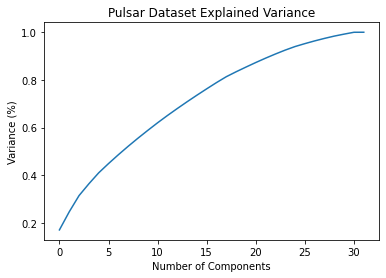

In [494]:
# Fit PCA
pca = PCA().fit(combined_df5) 

# Select the number of components based on the explained variance
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') 
plt.title('Pulsar Dataset Explained Variance')
plt.show()

In [495]:
pca = PCA(n_components=4)

pca.fit_transform(combined_df5)

print (pca.explained_variance_)
#print (pca.explained_variance_ratio_)
#print (pca.explained_variance_ratio_.cumsum())

pca_rescaled = pca.fit_transform(combined_df5)
# Save components to a DataFrame
PCA_components = pd.DataFrame(pca_rescaled)

[5.17874251 2.30988375 2.06828556 1.50176825]


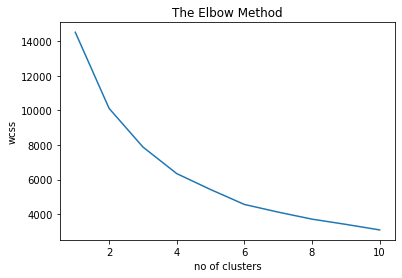

In [496]:
# Elbow Method: small inertia

score = []

for cluster in range(1,11):
    kmeans = KMeans(n_clusters = cluster, init="k-means++", random_state=10)
    kmeans.fit(PCA_components)
    score.append(kmeans.inertia_)
    
# plotting the score

plt.plot(range(1,11), score)
plt.title('The Elbow Method')
plt.xlabel('no of clusters')
plt.ylabel('wcss')
plt.show()

In [497]:
# Silhouette score: close to 1 

for clusters in range(2,11):
 
 kmeans = KMeans(n_clusters=clusters)
 kmeans.fit(PCA_components)
 cluster_labels = kmeans.labels_
 print("On cluster:",clusters,"Silhouette score:",silhouette_score(PCA_components, cluster_labels))

On cluster: 2 Silhouette score: 0.4079844890937101
On cluster: 3 Silhouette score: 0.3985519025843822
On cluster: 4 Silhouette score: 0.41080415724012337
On cluster: 5 Silhouette score: 0.42853527159830024
On cluster: 6 Silhouette score: 0.4154333097384924
On cluster: 7 Silhouette score: 0.3570653361008212
On cluster: 8 Silhouette score: 0.36730560129348827
On cluster: 9 Silhouette score: 0.36556831914253746
On cluster: 10 Silhouette score: 0.3591774572815528


In [504]:
# Kmeans with k=3

kmeans = KMeans(n_clusters=3)
kmeans.fit(PCA_components)
y_kmeans = kmeans.predict(PCA_components)
y_kmeans

array([0, 0, 0, ..., 0, 2, 2], dtype=int32)

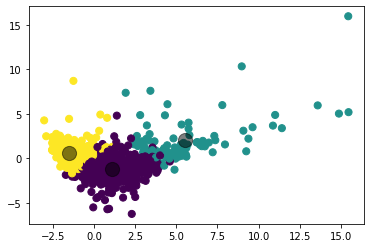

In [505]:
# Visualize clusters

plt.scatter(PCA_components[0], PCA_components[1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=200, alpha=0.5)

In [506]:
# Bring cluster value per user
cluster_df=pd.DataFrame(y_kmeans)
cluster_df= cluster_df.rename({0: 'Cluster'}, axis=1)

cluster_combined_df = pd.concat([cluster_df, combined_df], axis = 1)
cluster_combined_df.groupby('Cluster').agg({'UserID':['nunique']})

,UserID
,nunique
Cluster,
0,511
1,92
2,710


## Profiling 

### 1. Dataset for profiling

In [507]:
# a. One hot encoding users df

# One hot encoding for region
country_enc=pd.get_dummies(users.CountryName)

country_enc.reset_index(drop=True,inplace=True)
users.reset_index(drop=True,inplace=True)

users = pd.concat([users, country_enc], axis=1)

# One hot encoding for gender
gender_enc=pd.get_dummies(users.Sex)

gender_enc.reset_index(drop=True,inplace=True)

users = pd.concat([users, gender_enc], axis=1)

# One hot encoding for age
age_enc=pd.get_dummies(users.Age)
age_enc.columns = [str(col) + '_Age' for col in age_enc.columns]

age_enc.reset_index(drop=True,inplace=True)

users = pd.concat([users, age_enc], axis=1)

# One hot encoding for status
status_enc=pd.get_dummies(users.StatusSysname)

status_enc.reset_index(drop=True,inplace=True)

users = pd.concat([users, status_enc], axis=1)


In [508]:
#Remove useless columns from user df
users2 = users.drop(['BirthDate', 'ZipCode','CountryName','Sex',
                    'Registration Date','City',
                    'CountryId','StatusSysname'], axis=1)
#users2.shape,users2.UserID.nunique()

In [509]:
# b. One hot encoding on wallet
methodpaym_enc=pd.get_dummies(wallet.MethodSysname)

methodpaym_enc.reset_index(drop=True,inplace=True)
wallet.reset_index(drop=True,inplace=True)

wallet = pd.concat([wallet, methodpaym_enc], axis=1)

In [422]:
#Remove useless columns from wallet df
wallet2 = wallet.drop(['WalletActionId', 'Type','TypeSysname','Amount',
                    'MethodSysname','Created'], axis=1)
wallet2=wallet2.drop_duplicates(['UserID']) #unique customers
#wallet2.shape,wallet2.UserID.nunique()

In [510]:
combined_df.shape,combined_df.UserID.nunique()

((1313, 36), 1313)

In [511]:
# Merge dfs
profiling_df= combined_df.merge(users2,on='UserID',how='left').merge(wallet2,on='UserID',how='left')
profiling_df.shape,profiling_df.UserID.nunique() # = combined_df.shape

# Add profit or loss KPI
profiling_df= profiling_df.merge(combined_df3[['UserID','Profit','Loss']],on='UserID',how='left')

#Bring the cluster for each user
profiling_df2= profiling_df.merge(cluster_combined_df[['UserID','Cluster']],on='UserID',how='left')
profiling_df2.shape

# Conver to numeric before aggregations
cols = profiling_df2.columns.drop('UserID')
profiling_df2[cols] = profiling_df2[cols].apply(pd.to_numeric, errors='coerce')

### 2. Profiling aggregations
1. Total average values in whole population
2. Total average values per cluster

In [512]:
# create a new df to assign a col of 0s to calculate the total averages per KPI
features_clusters_zeros = profiling_df2.assign(zero_col=0)

# drop some features to do the pivot
features_clusters_zeros2 = features_clusters_zeros.drop(['UserID','Cluster','Profit or Loss'], axis=1)

# pivot total averages per KPI
pvt_totals = pd.pivot_table(features_clusters_zeros2,index=['zero_col'], aggfunc=np.mean)

tr_totals = pvt_totals.transpose()

tr_totals = tr_totals.reset_index()
tr_totals = tr_totals.rename(columns = {'index':'KPIs', 0:'Total_KPI_avg'})
tr_totals.to_excel(r'profiling_results_totals.xlsx', index = True)

In [513]:
#pivot all KPIs, mean value for each KPI per cluster
pvt_avg_kpi_clst = pd.pivot_table(profiling_df2, index=['Cluster'], aggfunc=np.mean)
# pvt_avg_kpi_clst.head()

#Transpose data
tr_avg_kpi_clst = pvt_avg_kpi_clst.transpose()
tr_avg_kpi_clst.head()

#Reset index to rename columns
tr_avg_kpi_clst.reset_index(inplace=True)
tr_avg_kpi_clst
tr_avg_kpi_clst = tr_avg_kpi_clst.rename(columns = {'index':'KPIs', 0:'Avg_Cluster_1', 1:'Avg_Cluster_2', 2:'Avg_Cluster_3'})
tr_avg_kpi_clst.to_excel(r'profiling_results_cluster.xlsx', index = True)
tr_avg_kpi_clst


Cluster,KPIs,Avg_Cluster_1,Avg_Cluster_2,Avg_Cluster_3
0,121.0_Age,0.000000,0.000000,0.000000
1,18.0_Age,0.000000,0.000000,0.001408
2,19.0_Age,0.000000,0.000000,0.000000
3,20.0_Age,0.000000,0.000000,0.002817
4,21.0_Age,0.123288,0.097826,0.070423
...,...,...,...,...
127,VivaWallet,0.000000,0.000000,0.000000
128,WITHDRAW_Frequency,3.667906,4.947826,0.779437
129,WITHDRAW_Recency,11.084149,10.891304,5.791549
130,WITHDRAW_mean,89.867443,138.498661,116.504917
